# Two moment retrieval

An idealized cloud model is applied to investigate the potential of combining RADAR with passive microwave and sub-millimeter observations to retrieve distributions of ice hydrometeors in the atmospheric column.

In [1]:
%env LIRAS_PATH=/old/projects/LIRAS/Development/liras
%env ARTS_BUILD_PATH=/home/simonpf/build/arts_fast

env: LIRAS_PATH=/old/projects/LIRAS/Development/liras
env: ARTS_BUILD_PATH=/home/simonpf/build/arts_fast


### Particle size distribution

For the analysis, a modified version of the PSD used for the DARDAR retrievals is used. Instead of $N_0^*$ and $D_m$, this version uses mass density $m$ and $D_m$ as free parameters of the particle size distribution.

In [2]:
from parts.scattering.psd.d14 import D14
d14 = D14(-0.26, 4.0, 917.0)

### Frozen hydrometeors

For these simplified simulations we assume that only one type of frozen hydrometeors is present in the atmosphere. We model this one using the 8-column aggregate habit with the PSD defined above.

In [3]:
from mcrf.liras import ice_shape, ice_shape_meta
from parts.scattering import ScatteringSpecies

ice = ScatteringSpecies("ice", d14, ice_shape, ice_shape_meta)

As background atmosphere the same model as for the retrievals is used.

In [4]:
from parts.atmosphere            import Atmosphere1D
from parts.atmosphere.absorption import O2, N2, H2O
from parts.atmosphere.surface    import Tessem
from parts.simulation            import ArtsSimulation
from mcrf.liras.model_data       import MeanModelDataProvider

absorbers  = [O2(), N2(), H2O()]
scatterers = [ice]
atmosphere = Atmosphere1D(absorbers = absorbers,
                          scatterers = scatterers,
                          surface = Tessem())

data_provider = MeanModelDataProvider(99)

### A simplified cloud model

The idealized cloud model used for this study assumes a 2km-thick, homogeneous cloud layer at a given height.

In [5]:
import numpy as np
from mcrf.liras.model_data import MeanModelDataProvider
from parts.data_provider import CombinedProvider

class HomogeneousCloud:
    def __init__(self, height, thickness, moment_names, ranges):
        self.height       = height
        self.thickness    = thickness
        self.ranges       = ranges
        self.z            = data_provider.get_altitude()
        self.x            = np.logical_and(self.z >= self.height - 0.5 * self.thickness,
                                           self.z < self.height + 0.5 * self.thickness).astype(np.float64)
        
        name = "get_ice_" + moment_names[0]
        self.__dict__[name] = self.get_first_moment
        
        name = "get_ice_" + moment_names[1]
        self.__dict__[name] = self.get_second_moment
        
    def get_first_moment(self, i, j):
        return self.x * self.ranges[0][i]
    
    def get_second_moment(self, i, j):
        return self.x * self.ranges[1][j]

In [6]:
ranges = [np.logspace(-6, -3, 41),
          np.linspace(0.0, 1e-3, 41)]
homogeneous_cloud = HomogeneousCloud(10e3, 5e3, ice.psd.moment_names, ranges)

In [7]:
homogeneous_cloud.ranges[0][21]

3.758374042884443e-05

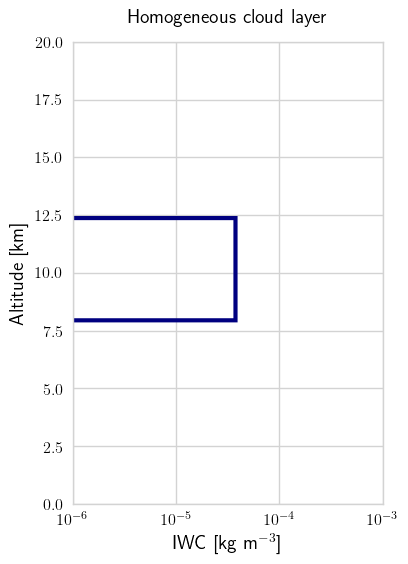

In [8]:
from mcrf.utils.setup_notebook import *
md = homogeneous_cloud.get_ice_mass_density(21, 21)
z = data_provider.get_altitude() / 1e3

f, ax = plt.subplots(1, 1, figsize = (4, 6))
ax.plot(md, z, c = "navy", lw = 3)
ax.set_xscale("log")
ax.set_xlim([1e-6, 1e-3])
ax.set_title("Homogeneous cloud layer")
ax.set_xlabel("IWC [kg  m$^{-3}$]")
ax.set_ylabel("Altitude [km]")
ax.set_ylim([0, 20])
f.savefig("../../plots/simple_cloud.pdf", bbox_inches = "tight")

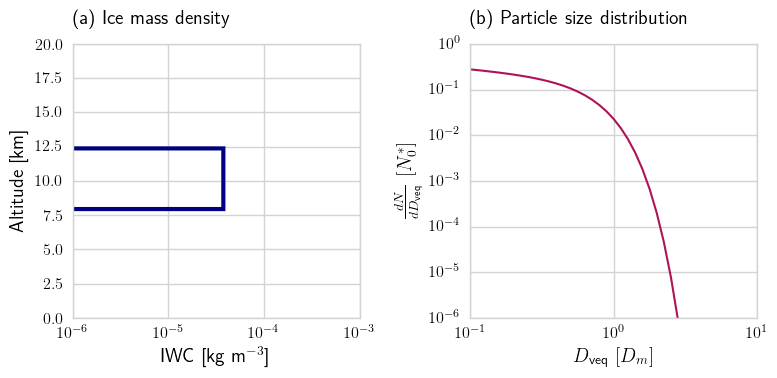

In [14]:
from mcrf.utils.setup_notebook import *
from matplotlib.gridspec import GridSpec

gs = GridSpec(1, 2, width_ratios = [1.0, 1.0])
md = homogeneous_cloud.get_ice_mass_density(21, 21)
z = data_provider.get_altitude() / 1e3

f = plt.figure(figsize = (8, 4))
ax = plt.subplot(gs[0, 0])
ax.plot(md, z, c = "navy", lw = 3)
ax.set_xscale("log")
ax.set_xlim([1e-6, 1e-3])
ax.set_title("(a) Ice mass density", loc = "left")
ax.set_xlabel("IWC [kg  m$^{-3}$]")
ax.set_ylabel("Altitude [km]")
ax.set_ylim([0, 20])

from mcrf.psds import D14NDmIce
psd = D14NDmIce()
ax = plt.subplot(gs[0, 1])
ax.set_title("(b) Particle size distribution", loc = "left")
psd.intercept_parameter = np.ones(1)
psd.mass_weighted_diameter = np.ones(1)
x = np.logspace(-1, 1, 41)
y = psd.evaluate(x).data
ax.plot(x, y.ravel())
ax.set_xlabel(r"$D_\text{veq}\ [D_m]$")
ax.set_ylabel(r"$\frac{dN}{dD_\text{veq}}\ [N_0^*]$")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_ylim([1e-6, 1e-0])
ax.set_xlim([1e-1, 1e1])

plt.tight_layout()


f.savefig("../../plots/simple_cloud_model.pdf", bbox_inches = "tight")

NameError: name 'homogeneous_cloud' is not defined

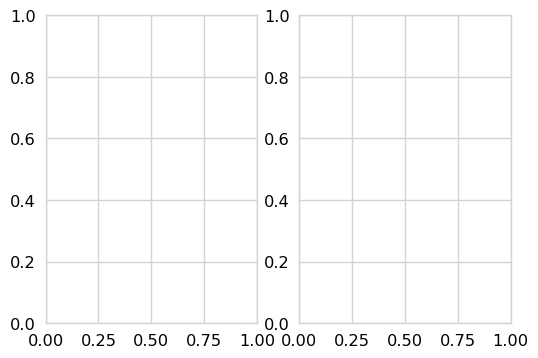

In [5]:
from mcrf.utils.setup_notebook import *
from mcrf.liras import ice

psd = ice.psd

f, axs = plt.subplots(1, 2, figsize = (6, 4))

ax = axs[0]
md = homogeneous_cloud.get_ice_mass_density(21, 21)
md = md / md.max() * 1e-4
z  = data_provider.get_altitude() / 1e3
ax.plot(md, z, c = "navy", lw = 3)
#ax.plot(2 * md, z, c = "navy", lw = 3, alpha = 0.8)
#ax.plot(4 * md, z, c = "navy", lw = 3, alpha = 0.6)
#ax.plot(8 * md, z, c = "navy", lw = 3, alpha = 0.4)
ax.set_xscale("log")
ax.set_xlim([1e-5, 1e-3])
ax.set_title("(a) Mass-density profile", loc = "left")
ax.set_xlabel("IWC [kg  m$^{-3}$]")
ax.set_ylabel("Altitude [km]")
ax.set_ylim([0, 20])
ax.set_xticklabels(["", "", r"$\propto N_0^* D_m^4$", ""])
f.savefig("../../plots/simple_cloud.pdf", bbox_inches = "tight")

ax = axs[1]
psd.intercept_parameter = np.ones(1)
psd.mass_weighted_diameter = np.ones(1)
x = np.logspace(-1, 1, 101)
y = psd.evaluate(x).data.ravel()
ax.plot(x, y, c = "firebrick", lw = 3)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_title(r"(b) Particle size distribution", loc = "left")
ax.set_xlabel(r"$D_eq$ [$D_m$]")
ax.set_ylabel(r"$\frac{dN}{dD_eq}$ [$N_0^*$]")
ax.set_xlim([0.1, 10.0])
ax.set_ylim([1e-4, 1])

plt.tight_layout()
f.savefig("../../plots/simulation_setup.pdf", bbox_inches = "tight")

In [16]:
psd.moment_names

['n0', 'dm']

In [16]:
from mcrf.sensors import lcpr, mwi, ici
simulation = ArtsSimulation(atmosphere = atmosphere,
                            sensors = [lcpr, mwi, ici],
                            data_provider = CombinedProvider(homogeneous_cloud, data_provider))

In [17]:
simulation.setup(verbosity = 0)

668.2 89.0


In [ ]:
from tqdm import trange

y_lcpr = []
y_mwi   = []
y_ici   = []

for i in trange(41):
    for j in range(41):
        simulation.run(i, j)
        y_lcpr += [np.copy(lcpr.y.ravel())]
        y_mwi  += [np.copy(mwi.y.ravel())]
        y_ici  += [np.copy(ici.y.ravel())]


 54%|█████▎    | 22/41 [3:09:07<2:43:15, 515.55s/it]

In [ ]:
simulation.run(0, 0)

In [34]:
y_lcpr = np.stack(y_lcpr).reshape(41, 41, -1)
y_mwi  = np.stack(y_mwi).reshape(41, 41, -1)
y_ici  = np.stack(y_ici).reshape(41, 41, -1)

In [35]:
np.savez("ys.npz", y_lcpr, y_mwi, y_ici)

In [18]:
results = np.load("ys.npz")
y_lcpr = results["arr_0"]
y_mwi = results["arr_1"]
y_ici = results["arr_2"]
(y_lcpr.shape, y_mwi.shape, y_ici.shape)

((41, 41, 39), (41, 41, 11), (41, 41, 11))

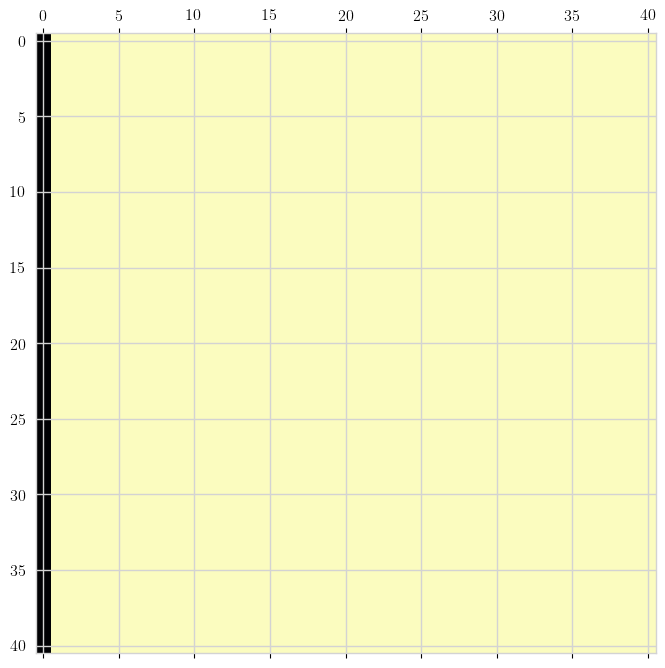

In [19]:
dy = y_mwi[:, :, 1] - y_mwi[0, 0, 1]
plt.matshow(dy < 0)

In [17]:
y_lcpr

'arr_0'

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linecolor'
  s)


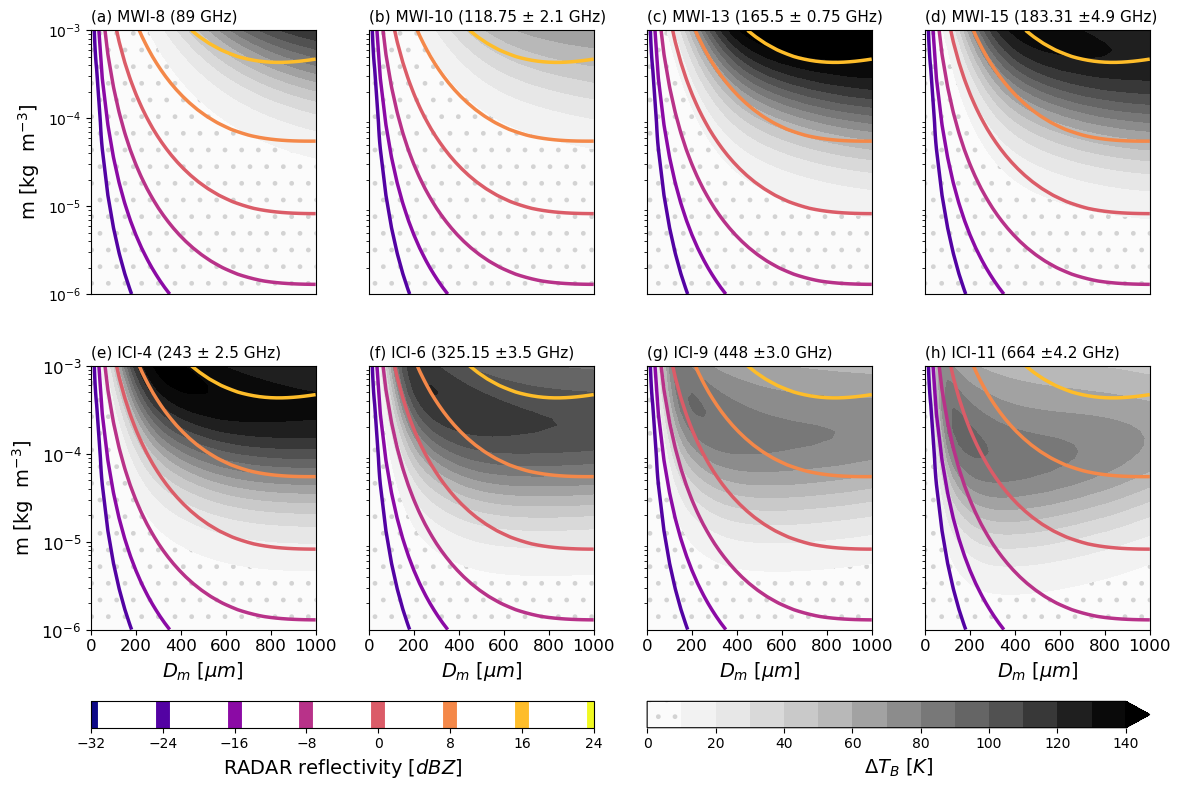

In [15]:
%matplotlib inline
from mcrf.utils import setup_notebook
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize, LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.color'] = "lightgrey"

import matplotlib.pyplot as plt


channels_mwi = [0, 2, 5, 8]
names_mwi = ["(a) MWI-8 (89 GHz)", "(b) MWI-10 (118.75 ± 2.1 GHz)", "(c) MWI-13 (165.5 ± 0.75 GHz)",
            "(d) MWI-15 (183.31 ±4.9 GHz)"]
channels_ici = [3, 5, 8, 10]
names_ici    = ["(e) ICI-4 (243 ± 2.5 GHz)", "(f) ICI-6 (325.15 ±3.5 GHz)",
                "(g) ICI-9 (448 ±3.0 GHz)", "(h) ICI-11 (664 ±4.2 GHz)"]

gs = GridSpec(3, 4, height_ratios = [1.0, 1.0, 0.1])
f = plt.figure(figsize = (12, 8))

m  = np.logspace(-6, -3, 41)
dm = np.linspace(0, 1e-3, 41) * 1e6


levels = np.linspace(0, 140, 15)
hatches = ["."] + [""] * 14
norm = Normalize(vmin = 0, vmax = 140)
for i, (c, n) in enumerate(zip(channels_mwi, names_mwi)):
    ax = plt.subplot(gs[0,i])
    y = y_mwi[:, :, c]
    y0 = y_mwi[0, 0, c]
    dy = y0 - y
    dy = np.maximum(dy, 1.0)
    cntr_p = ax.contourf(dm, m, dy, cmap = "Greys", norm = norm, extend = "max",
                         levels = levels, linestyles = [":"], hatches = hatches, linecolor = "grey")
    z = np.max(y_lcpr[:, :, :], axis = -1)
    ax.contour(dm, m, z, cmap = "plasma", linewidths = [2.5])
    ax.set_xlim([0.0, 1e3])
    ax.set_yscale("log")
    ax.set_title(n, loc = "left", fontsize = 11)
    
    if i == 0:
        ax.set_ylabel("m [kg  m$^{-3}$]", fontsize = 14)
    
    ax.set_xticks([])
    if i > 0:
        ax.set_yticks([])
    
for i, (c, n) in enumerate(zip(channels_ici, names_ici)):
    ax = plt.subplot(gs[1,i])
    y = y_ici[:, :, c]
    y0 = y_ici[0, 0, c]
    dy = y0 - y
    dy = np.maximum(dy, 1e-6)
    ax.contourf(dm, m, dy, cmap = "Greys", norm = norm, levels = levels, hatches = hatches, extend = "max")
    #ax.contour(dm, m, dy, colors = "k", norm = norm, levels = levels, linestyles = [":"])
    z = np.max(y_lcpr[:, :, :], axis = -1)
    cntr_r = ax.contour(dm, m, z, cmap = "plasma", linewidths = [2.5])
    ax.set_xlim([0.0, 1e3])
    ax.set_xlabel("$D_m$ [$\mu m$]", fontsize = 14)
    ax.set_yscale("log")
    ax.set_title(n, loc = "left", fontsize = 11)
    
    if i == 0:
        ax.set_ylabel("m [kg  m$^{-3}$]", fontsize = 14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(12)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
        
    if i > 0:
        ax.set_yticks([])
    
ax = plt.subplot(gs[-1, :2])
cntr_r.linewidths = [6.0]
cbar = plt.colorbar(cntr_r, cax = ax, label = "RADAR reflectivity [$dBZ$]", orientation = "horizontal")
cbar.ax.xaxis.label.set_fontsize(14)
lc = ax.get_children()[0]
lc.set_linewidths([10.0])

ax = plt.subplot(gs[-1, 2:])
cbar = plt.colorbar(cntr_p, cax = ax, label = "$\Delta T_B$ [$K$]", orientation = "horizontal")
cbar.ax.xaxis.label.set_fontsize(14)
ps = ax.get_children()[0]
ps.set_edgecolor("lightgrey")

plt.tight_layout()
plt.savefig("../../plots/contours.pdf", bbox_inches = "tight")

In [ ]:
%matplotlib inline
from mcrf.utils import setup_notebook
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize, LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.color'] = "lightgrey"

import matplotlib.pyplot as plt


channels_mwi = [0, 2, 5, 8]
names_mwi = ["(a) MWI-8 (89 GHz)", "(b) MWI-10 (118.75 ± 2.1 GHz)", "(c) MWI-13 (165.5 ± 0.75 GHz)",
            "(d) MWI-15 (183.31 ±4.9 GHz)"]
channels_ici = [3, 5, 8, 10]
names_ici    = ["(e) ICI-4 (243 ± 2.5 GHz)", "(f) ICI-6 (325.15 ±3.5 GHz)",
                "(g) ICI-9 (448 ±3.0 GHz)", "(h) ICI-11 (664 ±4.2 GHz)"]

gs = GridSpec(3, 4, height_ratios = [1.0, 1.0, 0.1])
f = plt.figure(figsize = (12, 8))

m  = np.logspace(-6, -3, 41)
dm = np.linspace(0, 1e-3, 41) * 1e6


levels = np.linspace(0, 140, 15)
hatches = ["."] + [""] * 14
norm = Normalize(vmin = 0, vmax = 140)
for i, (c, n) in enumerate(zip(channels_mwi, names_mwi)):
    ax = plt.subplot(gs[0,i])
    y = y_mwi[:, :, c]
    y0 = y_mwi[0, 0, c]
    dy = y0 - y
    dy = np.maximum(dy, 1.0)
    cntr_p = ax.contourf(dm, m, dy, cmap = "Greys", norm = norm, extend = "max",
                         levels = levels, linestyles = [":"], hatches = hatches, linecolor = "grey")
    z = np.max(y_lcpr[:, :, :], axis = -1)
    ax.contour(dm, m, z, cmap = "plasma", linewidths = [2.5])
    ax.set_xlim([0.0, 1e3])
    ax.set_yscale("log")
    ax.set_title(n, loc = "left", fontsize = 11)
    
    if i == 0:
        ax.set_ylabel("m [kg  m$^{-3}$]", fontsize = 14)
    
    ax.set_xticks([])
    if i > 0:
        ax.set_yticks([])
    
for i, (c, n) in enumerate(zip(channels_ici, names_ici)):
    ax = plt.subplot(gs[1,i])
    y = y_ici[:, :, c]
    y0 = y_ici[0, 0, c]
    dy = y0 - y
    dy = np.maximum(dy, 1e-6)
    ax.contourf(dm, m, dy, cmap = "Greys", norm = norm, levels = levels, hatches = hatches, extend = "max")
    #ax.contour(dm, m, dy, colors = "k", norm = norm, levels = levels, linestyles = [":"])
    z = np.max(y_lcpr[:, :, :], axis = -1)
    cntr_r = ax.contour(dm, m, z, cmap = "plasma", linewidths = [2.5])
    ax.set_xlim([0.0, 1e3])
    ax.set_xlabel("$D_m$ [$\mu m$]", fontsize = 14)
    ax.set_yscale("log")
    ax.set_title(n, loc = "left", fontsize = 11)
    
    if i == 0:
        ax.set_ylabel("m [kg  m$^{-3}$]", fontsize = 14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(12)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
        
    if i > 0:
        ax.set_yticks([])
    
ax = plt.subplot(gs[-1, :2])
cntr_r.linewidths = [6.0]
cbar = plt.colorbar(cntr_r, cax = ax, label = "RADAR reflectivity [$dBZ$]", orientation = "horizontal")
cbar.ax.xaxis.label.set_fontsize(14)
lc = ax.get_children()[0]
lc.set_linewidths([10.0])

ax = plt.subplot(gs[-1, 2:])
cbar = plt.colorbar(cntr_p, cax = ax, label = "$\Delta T_B$ [$K$]", orientation = "horizontal")
cbar.ax.xaxis.label.set_fontsize(14)
ps = ax.get_children()[0]
ps.set_edgecolor("lightgrey")

plt.tight_layout()
plt.savefig("../../plots/contours.pdf", bbox_inches = "tight")

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: The following kwargs were not used by contour: 'linecolor'


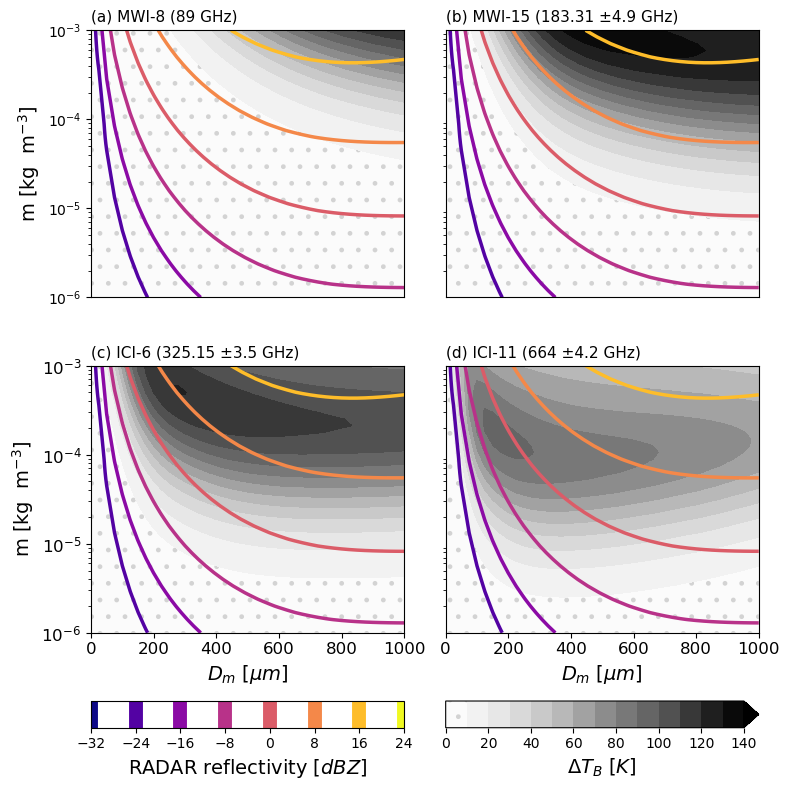

In [24]:
%matplotlib inline
from mcrf.utils import setup_notebook
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize, LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.color'] = "lightgrey"

import matplotlib.pyplot as plt


channels_mwi = [0, 8]
names_mwi = ["(a) MWI-8 (89 GHz)", "(b) MWI-15 (183.31 ±4.9 GHz)"]
channels_ici = [5, 10]
names_ici    = ["(c) ICI-6 (325.15 ±3.5 GHz)", "(d) ICI-11 (664 ±4.2 GHz)"]

gs = GridSpec(3, 2, height_ratios = [1.0, 1.0, 0.1])
f = plt.figure(figsize = (8, 8))

m  = np.logspace(-6, -3, 41)
dm = np.linspace(0, 1e-3, 41) * 1e6


levels = np.linspace(0, 140, 15)
hatches = ["."] + [""] * 14
norm = Normalize(vmin = 0, vmax = 140)
for i, (c, n) in enumerate(zip(channels_mwi, names_mwi)):
    ax = plt.subplot(gs[0,i])
    y = y_mwi[:, :, c]
    y0 = y_mwi[0, 0, c]
    dy = y0 - y
    dy = np.maximum(dy, 1.0)
    cntr_p = ax.contourf(dm, m, dy, cmap = "Greys", norm = norm, extend = "max",
                         levels = levels, linestyles = [":"], hatches = hatches, linecolor = "grey")
    z = np.max(y_lcpr[:, :, :], axis = -1)
    ax.contour(dm, m, z, cmap = "plasma", linewidths = [2.5])
    ax.set_xlim([0.0, 1e3])
    ax.set_yscale("log")
    ax.set_title(n, loc = "left", fontsize = 11)
    
    if i == 0:
        ax.set_ylabel("m [kg  m$^{-3}$]", fontsize = 14)
    
    ax.set_xticks([])
    if i > 0:
        ax.set_yticks([])
    
for i, (c, n) in enumerate(zip(channels_ici, names_ici)):
    ax = plt.subplot(gs[1,i])
    y = y_ici[:, :, c]
    y0 = y_ici[0, 0, c]
    dy = y0 - y
    dy = np.maximum(dy, 1e-6)
    ax.contourf(dm, m, dy, cmap = "Greys", norm = norm, levels = levels, hatches = hatches, extend = "max")
    #ax.contour(dm, m, dy, colors = "k", norm = norm, levels = levels, linestyles = [":"])
    z = np.max(y_lcpr[:, :, :], axis = -1)
    cntr_r = ax.contour(dm, m, z, cmap = "plasma", linewidths = [2.5])
    ax.set_xlim([0.0, 1e3])
    ax.set_xlabel("$D_m$ [$\mu m$]", fontsize = 14)
    ax.set_yscale("log")
    ax.set_title(n, loc = "left", fontsize = 11)
    
    if i == 0:
        ax.set_ylabel("m [kg  m$^{-3}$]", fontsize = 14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(12)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
        
    if i > 0:
        ax.set_yticks([])
    
ax = plt.subplot(gs[-1, :1])
cntr_r.linewidths = [6.0]
cbar = plt.colorbar(cntr_r, cax = ax, label = "RADAR reflectivity [$dBZ$]", orientation = "horizontal")
cbar.ax.xaxis.label.set_fontsize(14)
lc = ax.get_children()[0]
lc.set_linewidths([10.0])

ax = plt.subplot(gs[-1, 1:])
cbar = plt.colorbar(cntr_p, cax = ax, label = "$\Delta T_B$ [$K$]", orientation = "horizontal")
cbar.ax.xaxis.label.set_fontsize(14)
ps = ax.get_children()[0]
ps.set_edgecolor("lightgrey")

plt.tight_layout()
plt.savefig("../../plots/contours_1.pdf", bbox_inches = "tight")

/home/simonpf/build/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: The following kwargs were not used by contour: 'linecolor'


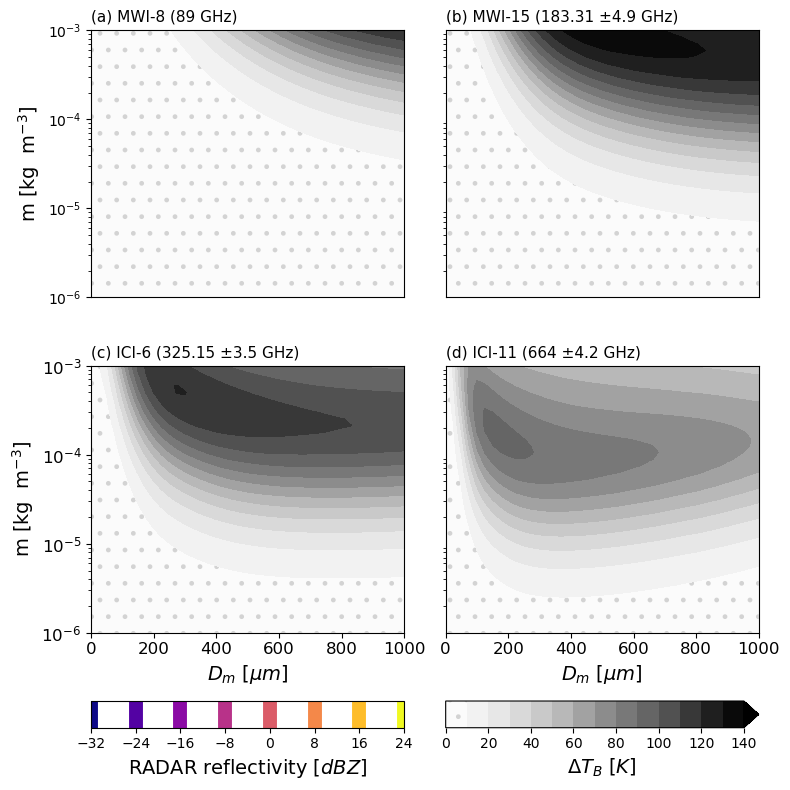

In [26]:
%matplotlib inline
from mcrf.utils import setup_notebook
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize, LogNorm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.color'] = "lightgrey"

import matplotlib.pyplot as plt


channels_mwi = [0, 8]
names_mwi = ["(a) MWI-8 (89 GHz)", "(b) MWI-15 (183.31 ±4.9 GHz)"]
channels_ici = [5, 10]
names_ici    = ["(c) ICI-6 (325.15 ±3.5 GHz)", "(d) ICI-11 (664 ±4.2 GHz)"]

gs = GridSpec(3, 2, height_ratios = [1.0, 1.0, 0.1])
f = plt.figure(figsize = (8, 8))

m  = np.logspace(-6, -3, 41)
dm = np.linspace(0, 1e-3, 41) * 1e6


levels = np.linspace(0, 140, 15)
hatches = ["."] + [""] * 14
norm = Normalize(vmin = 0, vmax = 140)
for i, (c, n) in enumerate(zip(channels_mwi, names_mwi)):
    ax = plt.subplot(gs[0,i])
    y = y_mwi[:, :, c]
    y0 = y_mwi[0, 0, c]
    dy = y0 - y
    dy = np.maximum(dy, 1.0)
    cntr_p = ax.contourf(dm, m, dy, cmap = "Greys", norm = norm, extend = "max",
                         levels = levels, linestyles = [":"], hatches = hatches, linecolor = "grey")
    z = np.max(y_lcpr[:, :, :], axis = -1)
    ax.set_xlim([0.0, 1e3])
    ax.set_yscale("log")
    ax.set_title(n, loc = "left", fontsize = 11)
    
    if i == 0:
        ax.set_ylabel("m [kg  m$^{-3}$]", fontsize = 14)
    
    ax.set_xticks([])
    if i > 0:
        ax.set_yticks([])
    
for i, (c, n) in enumerate(zip(channels_ici, names_ici)):
    ax = plt.subplot(gs[1,i])
    y = y_ici[:, :, c]
    y0 = y_ici[0, 0, c]
    dy = y0 - y
    dy = np.maximum(dy, 1e-6)
    ax.contourf(dm, m, dy, cmap = "Greys", norm = norm, levels = levels, hatches = hatches, extend = "max")
    z = np.max(y_lcpr[:, :, :], axis = -1)
    ax.set_xlim([0.0, 1e3])
    ax.set_xlabel("$D_m$ [$\mu m$]", fontsize = 14)
    ax.set_yscale("log")
    ax.set_title(n, loc = "left", fontsize = 11)
    
    if i == 0:
        ax.set_ylabel("m [kg  m$^{-3}$]", fontsize = 14)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(12)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
        
    if i > 0:
        ax.set_yticks([])
    
ax = plt.subplot(gs[-1, :1])
cntr_r.linewidths = [6.0]
cbar = plt.colorbar(cntr_r, cax = ax, label = "RADAR reflectivity [$dBZ$]", orientation = "horizontal")
cbar.ax.xaxis.label.set_fontsize(14)
lc = ax.get_children()[0]
lc.set_linewidths([10.0])

ax = plt.subplot(gs[-1, 1:])
cbar = plt.colorbar(cntr_p, cax = ax, label = "$\Delta T_B$ [$K$]", orientation = "horizontal")
cbar.ax.xaxis.label.set_fontsize(14)
ps = ax.get_children()[0]
ps.set_edgecolor("lightgrey")

plt.tight_layout()
plt.savefig("../../plots/contours_0.pdf", bbox_inches = "tight")